In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join

In [3]:
onlyfiles = [f for f in listdir("../measurement/output/20250207_odmr_tracking_snr/") if isfile(join("../measurement/output/20250207_odmr_tracking_snr/", f))]
onlyfiles

['data_dev_pulsed_odmr_tracking_changedetection_1738969052.74927_runlen_10.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1738969170.3873248_runlen_60.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1738969324.7462828_runlen_120.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1738969536.9288688_runlen_180.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1738969806.6307354_runlen_240.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1738970132.5246866_runlen_300.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1738971140.0006485_runlen_600.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1738973427.3779132_runlen_1.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1739303840.0672069_runlen_1.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1739304021.0119052_runlen_100.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1739304349.0267253_runlen_150.pkl',
 'data_dev_pulsed_odmr_tracking_changedetection_1739304760.2964664_runlen_170.pkl',


In [4]:
import re

def extract_runlen_numbers(filenames):
    numbers = []
    pattern = re.compile(r'_runlen_(\d+)\.pkl$')
    
    for filename in filenames:
        match = pattern.search(filename)
        if match:
            numbers.append(int(match.group(1)))
    
    return numbers

In [5]:
print(extract_runlen_numbers(onlyfiles))

[10, 60, 120, 180, 240, 300, 600, 1, 1, 100, 150, 170, 110, 130, 5, 20, 20, 30, 40, 50, 70, 80, 90, 1, 140, 190, 220, 350, 400, 450, 500, 550, 325, 375, 425, 475, 525, 700, 800, 900, 1200, 20, 120, 240]


In [6]:
def read_data(fname):
    try:
        with open(fname, "rb") as file:
            loaded_data = pickle.load(file)
        return loaded_data["buffer_data"], loaded_data["paraset"]
    except (FileNotFoundError, pickle.UnpicklingError) as e:
        print(f"Error loading file {fname}: {e}")
        return None, None
    
# Function to average repeated data
def average_repeated_data(array, start, stop, index, reps):
    data=[0,0,0,0]
    for i in range(4):
        arr=array[i]
        arr[:index, :] /= (reps + 1)
        arr[index:] /= reps
        data[i]=np.mean(arr[:, start:stop], axis=1)
    return data


def add_fft_trace(data, t_atrack):
    x=[0,0,0,0]
    y=[0,0,0,0]
    for i in range(4):
        buffer = data[i]
        freq = np.fft.fftfreq(len(buffer), (t_atrack / 1E9))
        sig_fft = np.abs(np.fft.fft(np.abs(buffer)))
        sig_fft -= np.abs(np.fft.fft(data[0]))
        positive_freqs = freq > 0
        x[i]=freq[positive_freqs]
        y[i]=(sig_fft)[positive_freqs]
    return x,y

def calculate_mean_noise_fft(fft_result,lower,higher,x): 
    loc = np.where((x[3] < lower) | (x[3] > higher))[0]
    magnitude_spectrum = np.abs(fft_result[loc])

    # Calculate the mean of the magnitude spectrum
    mean_magnitude = np.mean(magnitude_spectrum)
    # noise_threshold_multiplier = 0.6
    # # Define a threshold to separate noise from signal
    # noise_threshold = noise_threshold_multiplier * mean_magnitude

    # # Identify noise components (below the threshold)
    # noise_components = magnitude_spectrum[magnitude_spectrum < noise_threshold]

    # # Calculate the mean of the noise components
    # mean_noise = np.mean(noise_components) if noise_components.size > 0 else 0
    
    return mean_magnitude

In [17]:
SNR=np.zeros(len(onlyfiles))
times=np.zeros(len(onlyfiles))
signal_arr=np.zeros(len(onlyfiles))
noise_arr=np.zeros(len(onlyfiles))
loc_arr=np.zeros(len(onlyfiles))
for i in range(len(onlyfiles)):
    data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/"+onlyfiles[i])
    if data is not None:
        averaged_data = average_repeated_data(data, 0, 518, params['idx_pointer'], params['reps'])
        x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])
        indicies = np.where((x[3] >= 20) & (x[3] <= 50))[0]  # Get indices where x[3] is between 20 and 50
        lower=np.min(indicies)
        higher= np.max(indicies)
        signal=np.max(y[3][lower:higher])
        noise=calculate_mean_noise_fft(y[3],lower,higher,x)
        loc_arr[i] = np.argmax(y[3][lower:higher])
        signal_arr[i]=signal
        noise_arr[i]=noise
        SNR[i]=signal/noise
        
        times[i]=extract_runlen_numbers(onlyfiles)[i]

C:\Users\HFNV\AppData\Local\Temp\ipykernel_19228\3945691337.py:16: RuntimeWarning: invalid value encountered in divide
  arr[index:] /= reps


Text(0.5, 1.0, 'SNR vs Integration time')

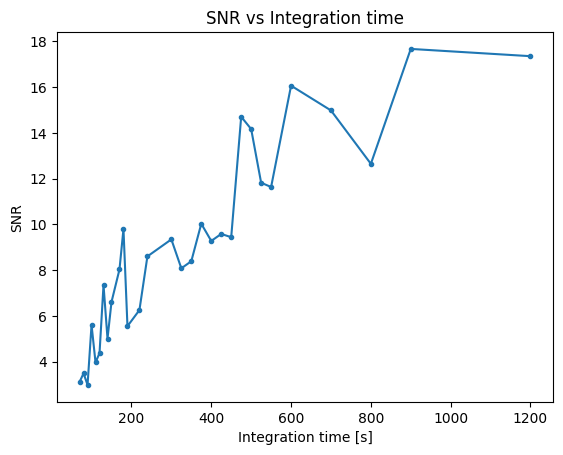

In [18]:
sorted_indices = np.argsort(times)
sorted_times = times[sorted_indices]
sorted_SNR = SNR[sorted_indices]
sorted_signal = signal_arr[sorted_indices]
sorted_noise = noise_arr[sorted_indices]
plt.plot(sorted_times[11:],sorted_SNR[11:],marker='.')
plt.xlabel("Integration time [s]")
plt.ylabel("SNR")
plt.title("SNR vs Integration time")

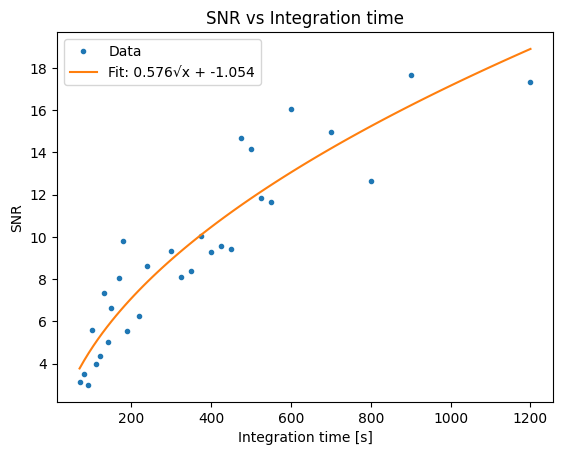

Fitted parameters: a = 0.576, b = -1.054
RMSD: 1.556


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the fitting function
def model(x, a, b):
    return a * np.sqrt(x) + b

# Sort data
sorted_indices = np.argsort(times)
sorted_times = times[sorted_indices]
sorted_SNR = SNR[sorted_indices]

# Use only values after index 11 for fitting
x_fit = sorted_times[11:]
y_fit = sorted_SNR[11:]

# Fit the curve
popt, pcov = curve_fit(model, x_fit, y_fit, p0=[1, 1])  # Initial guess for a, b

# Generate fitted values
y_model = model(x_fit, *popt)

# Calculate RMSD
rmsd = np.sqrt(np.mean((y_fit - y_model)**2))

# Generate values for plotting
x_plot = np.linspace(min(x_fit), max(x_fit), 100)
y_plot = model(x_plot, *popt)

# Plot the data and the fit
plt.plot(x_fit, y_fit, marker='.', linestyle='none', label="Data")
plt.plot(x_plot, y_plot, label=f"Fit: {popt[0]:.3f}√x + {popt[1]:.3f}")
plt.xlabel("Integration time [s]")
plt.ylabel("SNR")
plt.title("SNR vs Integration time")
plt.legend()
plt.show()

# Print fit parameters and RMSD
print(f"Fitted parameters: a = {popt[0]:.3f}, b = {popt[1]:.3f}")
print(f"RMSD: {rmsd:.3f}")


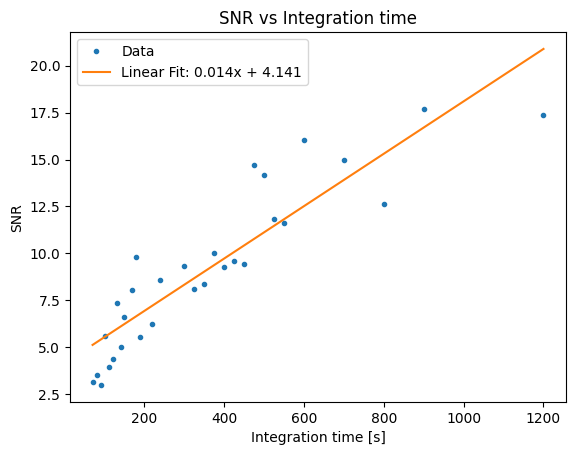

Linear fit parameters: a = 0.014, b = 4.141
RMSD for linear fit: 1.825


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the linear fitting function
def linear_model(x, a, b):
    return a * x + b

# Sort data
sorted_indices = np.argsort(times)
sorted_times = times[sorted_indices]
sorted_SNR = SNR[sorted_indices]

# Use only values after index 11 for fitting
x_fit = sorted_times[11:]
y_fit = sorted_SNR[11:]

# Fit the linear curve
popt, pcov = curve_fit(linear_model, x_fit, y_fit, p0=[1, 1])  # Initial guess for a, b

# Generate fitted values for the linear model
y_linear_model = linear_model(x_fit, *popt)

# Calculate RMSD for the linear fit
rmsd_linear = np.sqrt(np.mean((y_fit - y_linear_model)**2))

# Generate values for plotting
x_plot = np.linspace(min(x_fit), max(x_fit), 100)
y_plot_linear = linear_model(x_plot, *popt)

# Plot the data and the linear fit
plt.plot(x_fit, y_fit, marker='.', linestyle='none', label="Data")
plt.plot(x_plot, y_plot_linear, label=f"Linear Fit: {popt[0]:.3f}x + {popt[1]:.3f}")
plt.xlabel("Integration time [s]")
plt.ylabel("SNR")
plt.title("SNR vs Integration time")
plt.legend()
plt.show()

# Print fit parameters and RMSD
print(f"Linear fit parameters: a = {popt[0]:.3f}, b = {popt[1]:.3f}")
print(f"RMSD for linear fit: {rmsd_linear:.3f}")


Text(0, 0.5, 'Noise Amplitude')

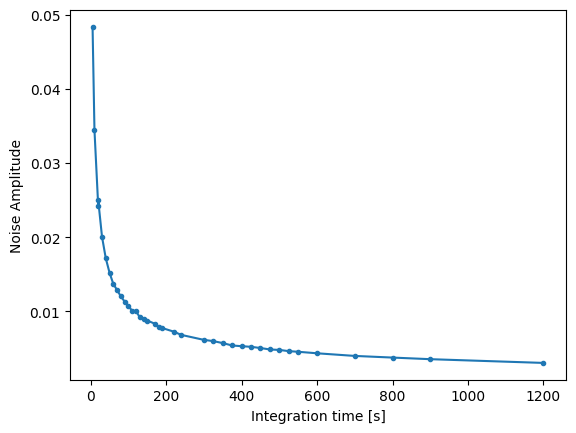

In [21]:
plt.plot(sorted_times,sorted_noise,marker='.')
plt.xlabel("Integration time [s]")
plt.ylabel("Noise Amplitude")

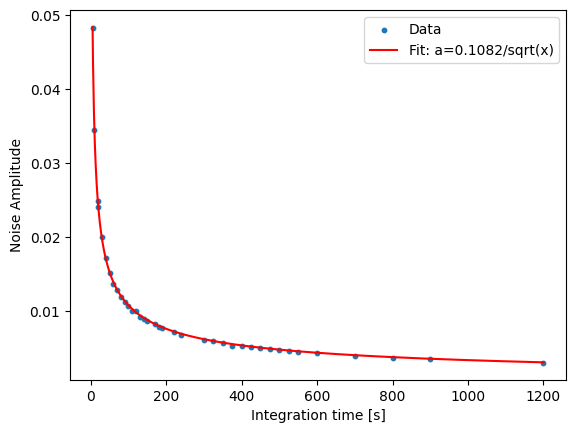

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the model function
def model(x, a):
    return a / np.sqrt(x)

# Load your data (replace with actual data loading)
# Example synthetic data (replace with your real data)
x_data = sorted_times
y_data = sorted_noise
valid_indices = np.isfinite(y_data)  # Keep only finite values
x_data = x_data[valid_indices]
y_data = y_data[valid_indices]

# Fit the model
popt, pcov = curve_fit(model, x_data, y_data, p0=[0.1])

# Extract fitted parameter
a_fit = popt[0]

# Generate fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = model(x_fit, a_fit)

# Plot results
plt.scatter(x_data, y_data, label="Data", s=10)
plt.plot(x_fit, y_fit, color='red', label=f"Fit: a={a_fit:.4f}/sqrt(x)")
plt.xlabel("Integration time [s]")
plt.ylabel("Noise Amplitude")
plt.legend()
plt.show()


In [ ]:
## 

In [27]:
data_list = []  # List to store (data, params) pairs

for i in range(len(onlyfiles)):
    data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/" + onlyfiles[i])
    data_list.append((data, params))  # Store as tuple


In [32]:
data_list[0][1]

{'mw_freq': 398.54667,
 'mw_hopspan': 0.007,
 'mw_powervolt': 5.0,
 'mw_phasevolt': 0.0,
 'min_volt': -0.01,
 'max_volt': 0.15,
 'laser_current': 95.0,
 'rf_freq': 600,
 'ninit_pihalf': 1000,
 't_lock_idle': 20,
 't_lock_rf': 3980,
 'n_lock': 2,
 't_lbloc_mwwait': 20.0,
 't_lbloc_mw': 7980.0,
 't_ribloc': 8000,
 't_ribloc_wait': 400.0,
 't_ribloc_isc': 800.0,
 't_ribloc_laser': 6800.0,
 't_fevol': 80000.0,
 't_brbloc': 8000,
 't_drbloc': 16000,
 't_cbloc': 48000.0,
 't_cbloc_laser': 10,
 't_cbloc_isc': 400,
 'n_cbloc_laser': 29,
 't_cbloc_pad': 36110.0,
 'n_track': 15000,
 'idx_pointer': 8640,
 'reps': 7}

In [35]:
np.shape(data_list[0][0])

(4, 15000, 2048)

In [39]:
import numpy as np
from scipy.optimize import dual_annealing

# Initialize arrays
SNR = np.zeros(len(onlyfiles))
times = np.zeros(len(onlyfiles))
signal_arr = np.zeros(len(onlyfiles))
noise_arr = np.zeros(len(onlyfiles))
loc_arr = np.zeros(len(onlyfiles))

# Define the objective function
def SNR_max(params):
    start, stop = params  # Extract parameters
    start, stop = int(1e6*start), int(1e6*stop)  # Ensure integer values

    # Enforce start < stop (penalty if violated)
    if start >= stop:
        print(f"[WARNING] Invalid start-stop pair: ({start}, {stop}) - Penalizing")
        return np.inf  

    print(f"\n[INFO] Evaluating SNR for start={start}, stop={stop}...")

    total_SNR = 0  # Track total SNR
    valid_entries = 0  # Count valid datasets

    for i in range(len(onlyfiles)):
        print(f"  -> Processing file {i+1}/{len(onlyfiles)}: {onlyfiles[i]}")

        data, params = data_list[i][0], data_list[i][1]
        if data is not None:
            print("     - Data successfully loaded.")

            averaged_data = average_repeated_data(data, start, stop, params['idx_pointer'], params['reps'])
            x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

            indices = np.where((x[3] >= 20) & (x[3] <= 50))[0]  # Select valid range
            if len(indices) == 0:
                print("     - No valid indices found in the range 20-50 Hz. Skipping.")
                continue  # Skip to next iteration

            lower, higher = np.min(indices), np.max(indices)
            signal = np.max(y[3][lower:higher])
            noise = calculate_mean_noise_fft(y[3], lower, higher, x)

            loc_arr[i] = np.argmax(y[3][lower:higher])
            signal_arr[i] = signal
            noise_arr[i] = noise
            SNR[i] = signal / noise
            times[i] = extract_runlen_numbers(onlyfiles)[i]
            total_SNR += SNR[i]
            valid_entries += 1

            print(f"     - Signal: {signal:.5f}, Noise: {noise:.5f}, SNR: {SNR[i]:.2f}")

    if valid_entries == 0:
        print("[WARNING] No valid SNR values computed. Returning high penalty.")
        return np.inf

    avg_SNR = total_SNR / valid_entries
    print(f"[RESULT] Computed total SNR: {total_SNR:.2f}, Average SNR: {avg_SNR:.2f}")

    return -total_SNR  # Negative because we want to maximize SNR

# Define bounds for start and stop
bounds = [(0, 2048/1e6), (0, 2048/1e6)]  # Both must be within 0 to 2048

print("[INFO] Starting dual annealing optimization...")
result = dual_annealing(SNR_max, bounds=bounds)
print("[INFO] Optimization complete!")

# Extract optimal start and stop
optimal_start, optimal_stop = result.x
print(f"\n[FINAL RESULT] Optimal Start: {optimal_start:.2f}, Optimal Stop: {optimal_stop:.2f}")


[INFO] Starting dual annealing optimization...

[INFO] Evaluating SNR for start=636, stop=1850...
  -> Processing file 1/41: data_dev_pulsed_odmr_tracking_changedetection_1738969052.74927_runlen_10.pkl
     - Data successfully loaded.
     - Signal: 0.00000, Noise: 0.00000, SNR: 45.59
  -> Processing file 2/41: data_dev_pulsed_odmr_tracking_changedetection_1738969170.3873248_runlen_60.pkl
     - Data successfully loaded.
     - Signal: 0.00000, Noise: 0.00000, SNR: 0.24
  -> Processing file 3/41: data_dev_pulsed_odmr_tracking_changedetection_1738969324.7462828_runlen_120.pkl
     - Data successfully loaded.
     - Signal: 0.00000, Noise: 0.00000, SNR: 0.42
  -> Processing file 4/41: data_dev_pulsed_odmr_tracking_changedetection_1738969536.9288688_runlen_180.pkl
     - Data successfully loaded.
     - Signal: 0.00000, Noise: 0.00000, SNR: 1.83
  -> Processing file 5/41: data_dev_pulsed_odmr_tracking_changedetection_1738969806.6307354_runlen_240.pkl
     - Data successfully loaded.
     

C:\Users\HFNV\AppData\Local\Temp\ipykernel_32992\337482697.py:48: RuntimeWarning: invalid value encountered in scalar divide
  SNR[i] = signal / noise


     - Signal: 0.00000, Noise: 0.00000, SNR: nan
[RESULT] Computed total SNR: nan, Average SNR: nan
[WARNING] Invalid start-stop pair: (1510, 818) - Penalizing
[WARNING] Invalid start-stop pair: (1176, 1166) - Penalizing

[INFO] Evaluating SNR for start=852, stop=1538...
  -> Processing file 1/41: data_dev_pulsed_odmr_tracking_changedetection_1738969052.74927_runlen_10.pkl
     - Data successfully loaded.
     - Signal: 0.00000, Noise: 0.00000, SNR: 45.41
  -> Processing file 2/41: data_dev_pulsed_odmr_tracking_changedetection_1738969170.3873248_runlen_60.pkl
     - Data successfully loaded.
     - Signal: -0.00000, Noise: 0.00000, SNR: -0.59
  -> Processing file 3/41: data_dev_pulsed_odmr_tracking_changedetection_1738969324.7462828_runlen_120.pkl
     - Data successfully loaded.
     - Signal: 0.00000, Noise: 0.00000, SNR: 0.31
  -> Processing file 4/41: data_dev_pulsed_odmr_tracking_changedetection_1738969536.9288688_runlen_180.pkl
     - Data successfully loaded.
     - Signal: 0.00

KeyboardInterrupt: 

In [52]:
import numpy as np
from scipy.optimize import dual_annealing

# Initialize arrays
SNR = np.zeros(len(onlyfiles))
times = np.zeros(len(onlyfiles))
signal_arr = np.zeros(len(onlyfiles))
noise_arr = np.zeros(len(onlyfiles))
loc_arr = np.zeros(len(onlyfiles))

# Define the objective function
data, parameters =     data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/" + onlyfiles[10])

def SNR_max(params):
    start, stop = params  # Extract parameters
    start, stop = int(10**6*start), int(10**6*stop)  # Ensure integer values

    # Enforce start < stop (penalty if violated)
    if start >= stop:
        return np.inf

    # print(f"\n[INFO] Evaluating SNR for start={int(start)}, stop={int(stop)}...")

    
    averaged_data = average_repeated_data(data, start, stop, parameters['idx_pointer'], parameters['reps'])
    x, y = add_fft_trace(averaged_data, parameters['t_ribloc'] + parameters['t_fevol'])

    indices = np.where((x[3] >= 20) & (x[3] <= 50))[0]  # Select valid range


    lower, higher = np.min(indices), np.max(indices)
    signal = np.max(y[3][lower:higher])
    noise = calculate_mean_noise_fft(y[3], lower, higher, x)

    print(signal/noise)     
    return -np.abs(signal/noise)  # Negative because we want to maximize SNR

# Define bounds for start and stop
bounds = [(0, 2048/(10**6)), (0, 2048/(10**6))]  # Both must be within 0 to 2048

result = dual_annealing(SNR_max, bounds=bounds)

# Extract optimal start and stop
optimal_start, optimal_stop = result.x
print(f"\n[FINAL RESULT] Optimal Start: {optimal_start:.2f}, Optimal Stop: {optimal_stop:.2f}")


3.214358958432709
2.976958392834002
4.585020153877624
2.7088676925029915
2.313551086493252
4.206500522178509
4.088861595934946
3.970423707925032
3.854382125859602


c:\Users\HFNV\.conda\envs\hfnvenv\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


3.741927398644359
3.6340436285923214
1.3198736484597418
2.1948208800841447
2.1307286955854985
1.9984015647829645
2.3720454235914854
5.240081410436965
5.1929981057869
5.147436253273937
5.10283126862246
5.05915389040606
5.016814672481463
4.975322173833632
2.778649253604718
1.2295064840989463
1.4306788028551543
3.9028415022229574
1.3170915861296155
1.1506987008416407
0.4039993401906857
1.4492906652142108
0.8557539363069088
0.6290191476730125
0.47133719684615666
1.073625934481638
0.5931323626163295
1.2704617177630182
0.6949700606043324
1.3365975599215925
0.720896566676168
1.1912768606485424
0.94098094387453
0.5998626847087228
0.3670398999326248
0.6121217135595696
0.8367425888901986
1.265079064544425
0.28800111306889653
0.3098630887224676
0.7799503085183459
0.5666562474000368
0.3884772672536629
0.12707641873811992
0.30241621811523256
0.5587260523318985
1.2747371108109895
3.0429451704537716
0.7170722901024406
0.13696904033015
0.6859762838450996
0.9998453544810378
0.8383492726084706
1.9810134

C:\Users\HFNV\AppData\Local\Temp\ipykernel_32992\3926258190.py:35: RuntimeWarning: invalid value encountered in scalar divide
  print(signal/noise)
C:\Users\HFNV\AppData\Local\Temp\ipykernel_32992\3926258190.py:36: RuntimeWarning: invalid value encountered in scalar divide
  return -np.abs(signal/noise)  # Negative because we want to maximize SNR


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


## READ IN FILES IF WANT TO LOOK AT 

In [54]:
optimal_start*10**6, optimal_stop*10**6

(1731.1437180238895, 1769.6904176279288)

In [19]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1739305799.2730615_runlen_5.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# # noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)
# np.max(y[3])

In [20]:
# loc = np.where((x[3] >= 20) & (x[3] <= 50))[0]  # Get indices where x[3] is between 20 and 50
# np.min(loc)
# np.max(loc)


In [21]:
# plt.plot(x[3][20:50])

In [22]:
# sorted_times[28]
# sorted_signal[28]

In [23]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1739306018.670696_runlen_40.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)


In [24]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1738969324.7462828_runlen_120.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)
# print(signal)


In [25]:
# print(sorted_times[8])
# sorted_signal[8]

In [ ]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/ddata_dev_pulsed_odmr_tracking_changedetection_1739311696.9315336_runlen_525.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)



In [19]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1738969806.6307354_runlen_240.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)
# SNR[4]=signal/noise
# times[4]=240

In [20]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1738970132.5246866_runlen_300.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)

# SNR[5]=signal/noise
# times[5]=300


In [21]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1738971140.0006485_runlen_600.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)

# SNR[6]=signal/noise
# times[6]=600

In [22]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1739304021.0119052_runlen_100.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)

# SNR[7]=signal/noise
# times[7]=100

In [23]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1739304349.0267253_runlen_150.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)

# SNR[8]=signal/noise
# times[8]=150

In [24]:
# data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1739304760.2964664_runlen_170.pkl")
# if data is not None:
#     averaged_data = average_repeated_data(data, 160, 400, params['idx_pointer'], params['reps'])
#     x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

# name = ["dark", "bright", "bg", "signal"]
# fig_fft = go.Figure()


# fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
# fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
# fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
# fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

# fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
#                       xaxis_title='Frequency [Hz]',
#                       yaxis_title='Amplitude')
# # Show plots
# fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
# signal=np.max(y[3])
# print(signal/noise)

# SNR[9]=signal/noise
# times[9]=170

In [25]:
# sorted_indices = np.argsort(times)
# sorted_times = times[sorted_indices]
# sorted_SNR = SNR[sorted_indices]
# plt.plot(sorted_times,sorted_SNR,marker='o')


In [8]:
data, params = read_data("../measurement/output/20250207_odmr_tracking_snr/data_dev_pulsed_odmr_tracking_changedetection_1739314872.4265556_runlen_900.pkl")
if data is not None:
    averaged_data = average_repeated_data(data, 0, 518, params['idx_pointer'], params['reps'])
    x, y = add_fft_trace(averaged_data, params['t_ribloc'] + params['t_fevol'])

name = ["dark", "bright", "bg", "signal"]
fig_fft = go.Figure()


fig_fft.add_trace(go.Scatter(x=x[0], y=y[0], mode='lines', name=name[0]))
fig_fft.add_trace(go.Scatter(x=x[1], y=y[1], mode='lines', name=name[1]))
fig_fft.add_trace(go.Scatter(x=x[2], y=y[2], mode='lines', name=name[2]))
fig_fft.add_trace(go.Scatter(x=x[3], y=y[3], mode='lines', name=name[3]))

fig_fft.update_layout(title='FFT of Signals (Positive Frequencies)',
                      xaxis_title='Frequency [Hz]',
                      yaxis_title='Amplitude')
# Show plots
fig_fft.show()
# noise=calculate_mean_noise_fft(y[3])
signal=np.max(y[3])
print(signal/noise)
np.max(y[3])

NameError: name 'noise' is not defined